# Queue baselines vs NOS


**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.

In [ ]:
from pathlib import Path
import sys
ROOT = Path('.').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


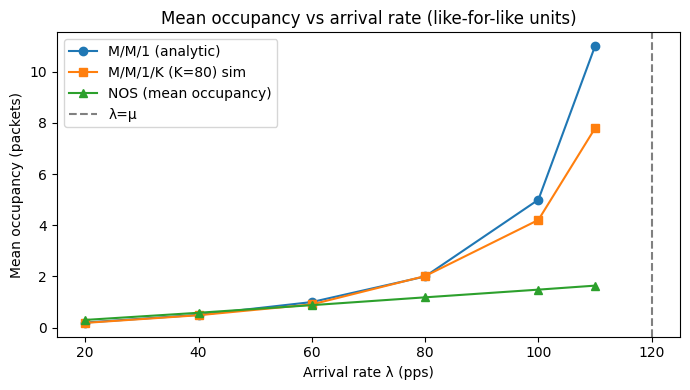

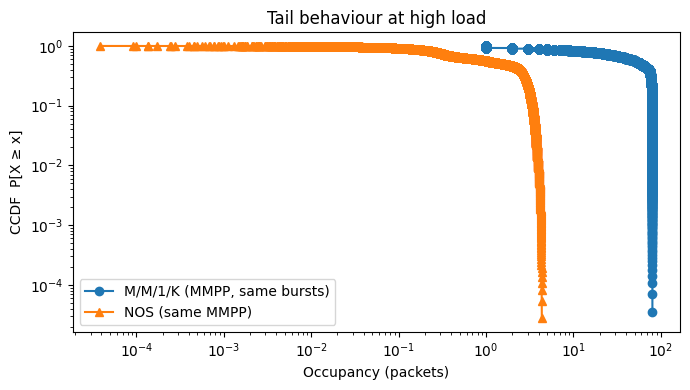

[Calibration] gain_I=2.0000, scale_v=0.4250
[Service tether] lam_leak=3.489619, chi=0.040000, effective linear service=120.00 pps (target μ=120.0)

[Step test with NOS alignment] metrics
  NOS: overshoot=0.00, settling=nans, IAE=243.20
  Queue: overshoot=0.50, settling=nans, IAE=46.73
  Queue (LP): overshoot=2.38, settling=nans, IAE=141.02


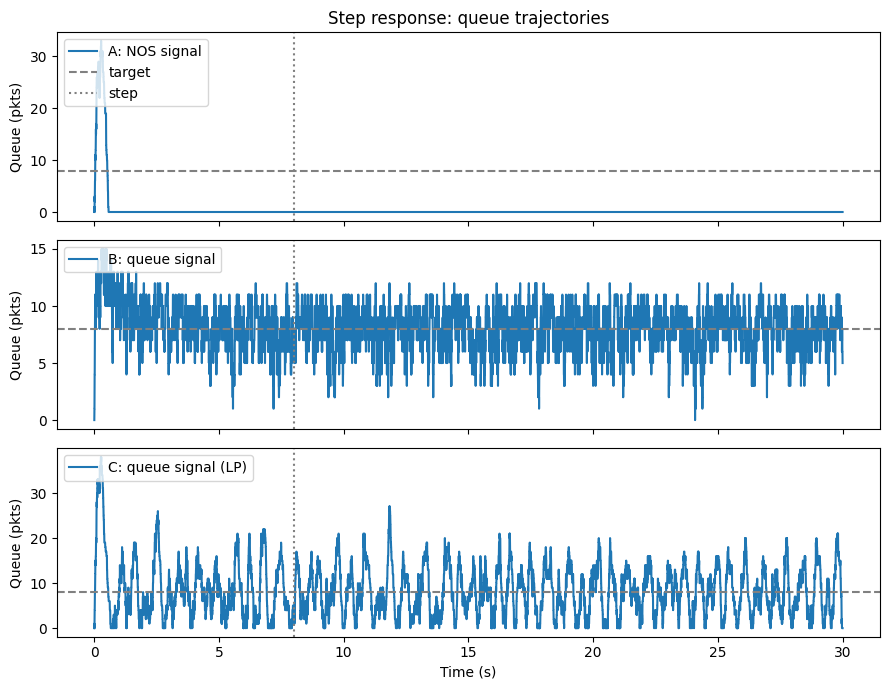

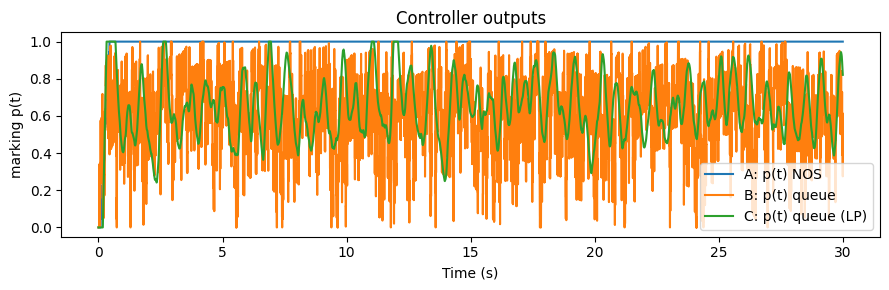


[Burst test with NOS alignment] high-percentile queues
  NOS: q95=14.0, q99=26.0, mean=1.8
  Queue: q95=14.0, q99=15.0, mean=5.7
  Queue (LP): q95=33.0, q99=45.0, mean=6.9


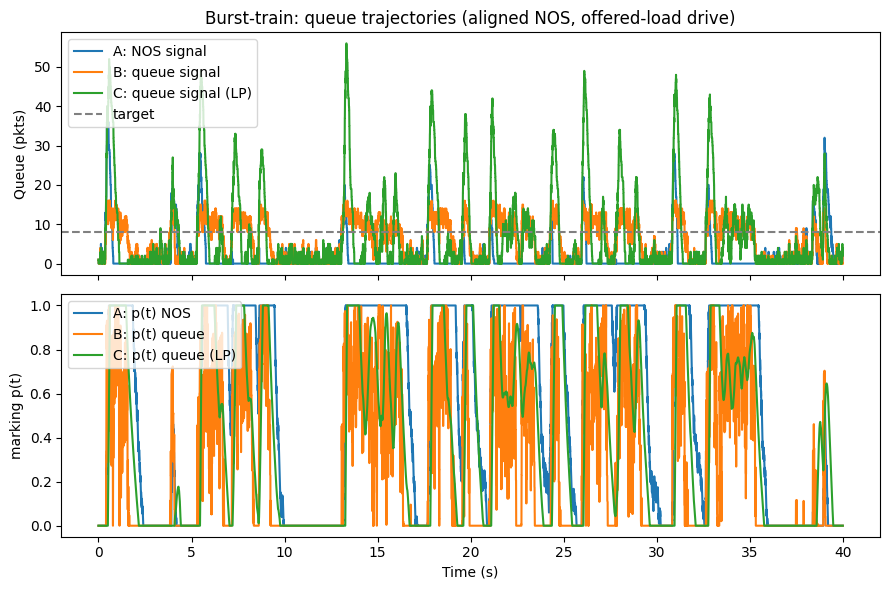

In [ ]:
# -*- coding: utf-8 -*-
# Queue baselines vs NOS — open-loop + closed-loop PI
#
# Notes:
# - This code uses a *scalar* NOS cell as a smooth proxy for occupancy (soft reset), not a full spiking network.
# - In the closed-loop AQM experiment, NOS is driven by *offered load (pre-drop)* as a proxy for upstream pressure.



import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys


_HERE = Path.cwd()
try:
    _HERE = Path(__file__).resolve().parent
except NameError:
    _HERE = Path.cwd()

if (_HERE / "src").exists():
    sys.path.insert(0, str(_HERE))
elif (_HERE.parent / "src").exists():
    sys.path.insert(0, str(_HERE.parent))

# Ground-truth NOS implementation
try:
    import src.nos as _nos_mod
    from src.nos import NOSParams, NOSState
except Exception:  # pragma: no cover
    import nos as _nos_mod
    from nos import NOSParams, NOSState

# Backward/forward compatibility
_NOS_STEP = getattr(_nos_mod, "nos_step_raw", None)
if _NOS_STEP is None:
    _NOS_STEP = getattr(_nos_mod, "nos_step", None)
if _NOS_STEP is None:
    raise ImportError("nos.py/src.nos must expose nos_step (or legacy nos_step_raw).")

import os
OUTDIR = os.path.join("outputs", "queue_mechanistic_baselines")
os.makedirs(OUTDIR, exist_ok=True)
SAVE_FIGS = True

# Reproducible RNGs
SEED_CAL = 41
SEED_RUN = 42
rng_cal = np.random.default_rng(SEED_CAL)
rng_run = np.random.default_rng(SEED_RUN)

# ---------------------------
# Queue & traffic (open-loop sims)
# -----------------------------
def simulate_mm1k(lam, mu, K, T, dt, rng):
    steps = int(T/dt)
    q = 0
    qs = np.empty(steps, dtype=float)
    for t in range(steps):
        a = rng.poisson(lam*dt)
        admit = min(a, max(K - q, 0))
        q += admit
        served = min(q, rng.poisson(mu*dt))
        q -= served
        qs[t] = q
    return qs

def simulate_mmpp(lam0, lam1, nu01, nu10, T, dt, rng):
    steps = int(T/dt)
    state = 0
    s = np.empty(steps, dtype=int)
    for t in range(steps):
        if state == 0 and rng.random() < nu01*dt: state = 1
        elif state == 1 and rng.random() < nu10*dt: state = 0
        s[t] = rng.poisson((lam1 if state==1 else lam0)*dt)
    return s

def ccdf(x):
    """Empirical CCDF for the plotted label P[X ≥ x]."""
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    x = np.sort(x)
    if len(x)==0:
        return np.array([0.0]), np.array([0.0])
    # P[X ≥ x_i] using the sorted sample order (no one-sample shift)
    p = 1.0 - np.arange(0, len(x))/len(x)
    return x, p

# -----------------------------
# NOS dynamics (open-loop sim)
# -------------------------
# NOS scalar proxy simulator (canonical, imported from src/nos.py)
def simulate_NOS(arrivals_per_bin, T, dt,
                 alpha=0.8, kappa=1.2, beta=0.05, gamma=0.0,
                 lam_leak=0.15, chi=0.04, vrest=0.0,
                 a=1.0, b=1.2, mu_adapt=0.05,
                 vth=0.8, c=0.1, d=0.2, rho_reset=6.0,
                 gain_I=1.0, bias_I=0.0):
    """Simulate scalar NOS proxy using the canonical step in `src/nos.py`.

    This reproduces the original update:
        v += dt * (f_sat(v) + beta*v + gamma - u + I - lam_leak*v - chi*(v-vrest))
        u += dt * (a*(b*v - u) - mu_adapt*u)
    with smooth reset:
        if v>=vth: v = c + (v-c)*exp(-rho_reset*dt); u += d
    """
    p = NOSParams(
        alpha=float(alpha), kappa=float(kappa),
        beta=float(beta), gamma=float(gamma),
        lam=float(lam_leak), chi=float(chi), v_rest=float(vrest),
        a=float(a), b=float(b), mu=float(mu_adapt),
        theta=float(vth), c_reset=float(c), rho_reset=float(rho_reset),
        du_spike=float(d),
    )
    steps = len(arrivals_per_bin)
    state = NOSState(v=np.array([0.0], dtype=float), u=np.array([0.0], dtype=float))
    vs = np.zeros(steps, dtype=float)

    # Deterministic here (no jitter, no noise), but keep one RNG for API consistency.
    rng = np.random.default_rng(0)

    for t in range(steps):
        I = float(bias_I + gain_I * arrivals_per_bin[t])
        state, _ = _NOS_STEP(state, np.array([I], dtype=float), float(dt), p, rng=rng, additive_noise=0.0)
        vs[t] = state.v[0]
    return vs

# -----------------------------
# Calibration (gain_I, scale_v) + service tether
# -----------------------------
def calibrate_nos_to_mm1(lams_pps, mu_pps, K, T, dt, B_packets,
                         alpha=0.8, kappa=1.2, beta=0.05, gamma=0.0,
                         lam_leak=0.15, chi=0.04, vrest=0.0,
                         a=1.0, b=1.2, mu_adapt=0.05, vth=0.8,
                         c=0.1, d=0.2, rho_reset=6.0, traces=None):
    gains = np.linspace(0.01, 2.0, 40)
    light = [lam for lam in lams_pps if lam < mu_pps]
    L = np.array([ (lam/mu_pps)/(1.0 - lam/mu_pps) for lam in light ], float)
    best_err, best = np.inf, (1.0, 1.0)
    for gI in gains:
        v_means = []
        for lam in light:
            arr = (traces[float(lam)] if traces is not None else rng_cal.poisson(lam*dt, size=int(T/dt)))
            v = simulate_NOS(arr, T, dt,
                             alpha,kappa,beta,gamma,
                             lam_leak,chi,vrest,
                             a,b,mu_adapt,vth,c,d,rho_reset,
                             gain_I=gI)
            v_means.append(np.mean(v))
        v_means = np.asarray(v_means)
        denom = (B_packets**2)*np.sum(v_means**2) + 1e-12
        numer = B_packets*np.sum(v_means*L)
        s_v = float(max(numer/denom, 1e-9))
        pred = s_v*B_packets*v_means
        mse = float(np.mean((pred - L)**2))
        if mse < best_err: best_err, best = mse, (gI, s_v)
    return best

# Global params
dt = 1e-3
T  = 40.0
mu_pps   = 120.0
lams_pps = np.array([20, 40, 60, 80, 100, 110])
K        = 80
B_packets = K


chi = 0.04
USE_LEGACY_CALIBRATION = True  # set True to reproduce the original one-pass calibration

def calibrate_consistent(lams_pps, mu_pps, K, T, dt, B_packets,
                         lam_leak_init=0.15, iters=3,
                         alpha=0.8, kappa=1.2, beta=0.05, gamma=0.0,
                         vrest=0.0, a=1.0, b=1.2, mu_adapt=0.05,
                         vth=0.8, c=0.1, d=0.2, rho_reset=6.0):
    # fixed calibration traces so iterations are comparable
    light = [lam for lam in lams_pps if lam < mu_pps]
    rng_local = np.random.default_rng(SEED_CAL)
    traces = {float(lam): rng_local.poisson(float(lam)*dt, size=int(T/dt)) for lam in light}

    lam_leak = float(lam_leak_init)
    gain_I = 1.0
    scale_v = 1.0
    for _ in range(int(iters)):
        gain_I, scale_v = calibrate_nos_to_mm1(
            lams_pps, mu_pps, K, T, dt, B_packets,
            alpha=alpha, kappa=kappa, beta=beta, gamma=gamma,
            lam_leak=lam_leak, chi=chi, vrest=vrest,
            a=a, b=b, mu_adapt=mu_adapt, vth=vth, c=c, d=d, rho_reset=rho_reset,
            traces=traces
        )
        lam_new = max(mu_pps/(scale_v*B_packets) - chi, 1e-6)
        if abs(lam_new - lam_leak) / max(lam_leak, 1e-9) < 1e-3:
            lam_leak = lam_new
            break
        lam_leak = lam_new
    return float(gain_I), float(scale_v), float(lam_leak)

if USE_LEGACY_CALIBRATION:
    gain_I, scale_v = calibrate_nos_to_mm1(lams_pps, mu_pps, K, T, dt, B_packets)
    lam_leak_eff = max(mu_pps/(scale_v*B_packets) - chi, 1e-6)
else:
    gain_I, scale_v, lam_leak_eff = calibrate_consistent(lams_pps, mu_pps, K, T, dt, B_packets)

NOSP = dict(alpha=0.8, kappa=1.2, beta=0.05, gamma=0.0,
            lam_leak=lam_leak_eff, chi=chi, vrest=0.0,
            a=1.0, b=1.2, mu_adapt=0.05,
            vth=0.8, c=0.1, d=0.2, rho_reset=6.0,
            gain_I=gain_I, bias_I=0.0)

# =============================
# Open-loop: mean vs λ
# =============================
means_mm1, means_mm1k, means_nos = [], [], []
for lam in lams_pps:
    rho = lam/mu_pps; means_mm1.append(rho/(1-rho))
    q = simulate_mm1k(lam, mu_pps, K, T, dt, rng_run)
    means_mm1k.append(np.mean(q))
    arr = rng_run.poisson(lam*dt, size=int(T/dt))
    v = simulate_NOS(arr, T, dt, **NOSP)
    occ = np.clip(scale_v*B_packets*v, 0, K)
    means_nos.append(np.mean(occ))

plt.figure(figsize=(7,4))
plt.plot(lams_pps, means_mm1,  'o-', label='M/M/1 (analytic)')
plt.plot(lams_pps, means_mm1k, 's-', label=f'M/M/1/K (K={K}) sim')
plt.plot(lams_pps, means_nos,  '^-', label='NOS (mean occupancy)')
plt.axvline(mu_pps, color='gray', ls='--', label='λ=μ')
plt.xlabel('Arrival rate λ (pps)'); plt.ylabel('Mean occupancy (packets)')
plt.title('Mean occupancy vs arrival rate (like-for-like units)')
plt.legend(); plt.tight_layout();
if SAVE_FIGS: plt.savefig(os.path.join(OUTDIR, "openloop_mean_vs_lambda.png"), dpi=240)
plt.show()

# =============================
# Open-loop: Tail CCDF (same MMPP drive)
# =============================
def simulate_mm1k_with_arrivals(arrivals_per_bin, mu, K, dt, rng):
    q = 0
    qs = np.empty_like(arrivals_per_bin, dtype=float)
    for t, a in enumerate(arrivals_per_bin):
        admit = min(int(a), max(K - q, 0))
        q += admit
        served = min(q, rng.poisson(mu*dt))
        q -= served
        qs[t] = q
    return qs

lam0, lam1 = 20.0, 200.0
nu01, nu10 = 0.6, 0.6
arr_mmpp = simulate_mmpp(lam0, lam1, nu01, nu10, T, dt, rng_run)
q_mmpp = simulate_mm1k_with_arrivals(arr_mmpp, mu_pps, K, dt, rng_run)
v = simulate_NOS(arr_mmpp, T, dt, **NOSP)
occ_nos = np.clip(scale_v*B_packets*v, 0, K)
x1,p1 = ccdf(q_mmpp[q_mmpp>0]); x2,p2 = ccdf(occ_nos[occ_nos>0])

plt.figure(figsize=(7,4))
plt.loglog(x1, p1, 'o-', label='M/M/1/K (MMPP, same bursts)')
plt.loglog(x2, p2, '^-', label='NOS (same MMPP)')
plt.xlabel('Occupancy (packets)'); plt.ylabel('CCDF  P[X ≥ x]')
plt.title('Tail behaviour at high load'); plt.legend(); plt.tight_layout();
if SAVE_FIGS: plt.savefig(os.path.join(OUTDIR, "openloop_tail_ccdf.png"), dpi=240)
plt.show()

print(f"[Calibration] gain_I={gain_I:.4f}, scale_v={scale_v:.4f}")
print(f"[Service tether] lam_leak={lam_leak_eff:.6f}, chi={chi:.6f}, "
      f"effective linear service={(lam_leak_eff+chi)*scale_v*B_packets:.2f} pps (target μ={mu_pps})")


# CLOSED-LOOP


def mm1k_step(q, a, mu, K, rng):
    admit = min(int(a), max(K - q, 0))
    q = q + admit
    served = min(q, rng.poisson(mu*dt))
    return float(q - served)

# -----------------------------
# Scalar NOS step (ground truth: nos.py)
# -----------------------------
def nos_step(v, u, a_offered, params):
    """One scalar-step wrapper around the ground-truth 'nos_step' in nos.py.

    inputs are floats (v,u) and scalar offered arrivals (a_offered).
    The mapping to NOSParams follows the paper notation:
        dv = f_sat(v) + (beta-lam-chi)*v + (gamma+chi*v_rest) - u + I
        du = a*(b*v - u) - mu*u
    Reset uses the smooth pullback (c_reset, rho_reset) and u kick (du_spike).
    """
    I = float(params.get("bias_I", 0.0) + params.get("gain_I", 1.0) * a_offered)

    p = NOSParams(
        alpha=float(params["alpha"]),
        kappa=float(params["kappa"]),
        beta=float(params["beta"]),
        gamma=float(params["gamma"]),
        lam=float(params["lam_leak"]),
        chi=float(params["chi"]),
        v_rest=float(params["vrest"]),
        a=float(params["a"]),
        b=float(params["b"]),
        mu=float(params["mu_adapt"]),
        theta=float(params["vth"]),
        c_reset=float(params["c"]),
        rho_reset=float(params["rho_reset"]),
        du_spike=float(params["d"]),
        thresh_jitter_std=0.0,
    )

    state = NOSState(v=np.array([float(v)], dtype=float), u=np.array([float(u)], dtype=float))
    state2, _ = _NOS_STEP(state, np.array([I], dtype=float), float(dt), p, rng=None, additive_noise=0.0)
    return float(state2.v[0]), float(state2.u[0])

def pi_controller(sig_packets, target_packets, kp, ki, dt, integ):
    err = (sig_packets - target_packets)/max(target_packets,1e-9)
    integ = integ + ki*err*dt
    p = kp*err + integ
    # clamp + simple anti-windup
    if p > 1.0: p = 1.0; integ = min(integ, 1.0)
    if p < 0.0: p = 0.0; integ = max(integ, 0.0)
    return float(p), float(integ)

def settling_time(series, target, tol_frac, dt, t_after=0.0):
    tol = tol_frac*max(target,1e-9); start = int(t_after/dt)
    for i in range(start, len(series)):
        if np.all(np.abs(series[i:] - target) <= tol): return i*dt
    return np.nan

# ---- Controller setup ----
T_step = 30.0; steps = int(T_step/dt); time = np.arange(steps)*dt
lam_lo, lam_hi = 80.0, 320.0
t_step = 8.0
target = 8.0
kp, ki = 0.9, 0.8
tau_lp = 0.4
alpha_lp = np.exp(-dt/tau_lp)

# ---- Unit alignment for NOS at the operating point (moved AFTER target is defined) ----
lam_ref = 1.2 * mu_pps
T_align = 8.0
steps_align = int(T_align/dt)
arr_align = rng_run.poisson(lam_ref*dt, size=steps_align)

v_tmp = 0.0; u_tmp = 0.0
vs_tmp = np.zeros(steps_align)
for t in range(steps_align):
    v_tmp, u_tmp = nos_step(v_tmp, u_tmp, arr_align[t], {**NOSP, "bias_I":0.0})
    vs_tmp[t] = v_tmp

mean_v_align = max(np.mean(vs_tmp), 1e-9)
g_align = float(target / (scale_v * B_packets * mean_v_align))

# offered load (pre-drop) used by all, and by NOS in particular
arr_offered = np.array([ rng_run.poisson((lam_lo if t<t_step else lam_hi)*dt)
                         for t in range(steps) ])

# States
qA=qB=qC = 0.0
vA=uA = 0.0
q_lp = 0.0
Q_A = np.zeros(steps); Q_B = np.zeros(steps); Q_C = np.zeros(steps)
P_A = np.zeros(steps); P_B = np.zeros(steps); P_C = np.zeros(steps)
I_A = I_B = I_C = 0.0

for t in range(steps):
    # signals: A from NOS driven by offered load; B/C from queue
    sA_packets = g_align * np.clip(scale_v*B_packets*vA, 0, K)
    sB_packets = qB
    q_lp = alpha_lp*q_lp + (1-alpha_lp)*qC
    sC_packets = q_lp

    # PI
    P_A[t], I_A = pi_controller(sA_packets, target, kp, ki, dt, I_A)
    P_B[t], I_B = pi_controller(sB_packets, target, kp, ki, dt, I_B)
    P_C[t], I_C = pi_controller(sC_packets, target, kp, ki, dt, I_C)

    # real arrivals and marking for each path
    a_off = arr_offered[t]
    aA = a_off - rng_run.binomial(a_off, P_A[t])
    aB = a_off - rng_run.binomial(a_off, P_B[t])
    aC = a_off - rng_run.binomial(a_off, P_C[t])

    qA = mm1k_step(qA, aA, mu_pps, K, rng_run)
    qB = mm1k_step(qB, aB, mu_pps, K, rng_run)
    qC = mm1k_step(qC, aC, mu_pps, K, rng_run)
    vA, uA = nos_step(vA, uA, a_off, {**NOSP, "bias_I":0.0})

    Q_A[t], Q_B[t], Q_C[t] = qA, qB, qC

# Metrics and plots
def step_metrics(q, label):
    overshoot = max(0.0, (np.max(q[int(t_step/dt):]) - target)/max(target,1e-9))
    st = settling_time(q, target, 0.1, dt, t_after=t_step)
    iae = float(np.sum(np.abs(q - target))*dt)
    return dict(label=label, overshoot=overshoot, settling=st, IAE=iae)

mA, mB, mC = step_metrics(Q_A,"NOS"), step_metrics(Q_B,"Queue"), step_metrics(Q_C,"Queue (LP)")
print("\n[Step test with NOS alignment] metrics")
for m in [mA,mB,mC]:
    print(f"  {m['label']}: overshoot={m['overshoot']:.2f}, settling={m['settling']:.2f}s, IAE={m['IAE']:.2f}")

fig, axes = plt.subplots(3, 1, figsize=(9,7), sharex=True)
axes[0].plot(time, Q_A, label="A: NOS signal"); axes[0].axhline(target, ls='--', color='gray', label="target")
axes[0].axvline(t_step, ls=':', color='gray', label="step")
axes[0].set_ylabel("Queue (pkts)"); axes[0].set_title("Step response: queue trajectories"); axes[0].legend(loc="upper left")
axes[1].plot(time, Q_B, label="B: queue signal"); axes[1].axhline(target, ls='--', color='gray'); axes[1].axvline(t_step, ls=':', color='gray')
axes[1].set_ylabel("Queue (pkts)"); axes[1].legend(loc="upper left")
axes[2].plot(time, Q_C, label="C: queue signal (LP)"); axes[2].axhline(target, ls='--', color='gray'); axes[2].axvline(t_step, ls=':', color='gray')
axes[2].set_ylabel("Queue (pkts)"); axes[2].set_xlabel("Time (s)"); axes[2].legend(loc="upper left")
plt.tight_layout();
if SAVE_FIGS: plt.savefig(os.path.join(OUTDIR, "closedloop_step_queues.png"), dpi=240)
plt.show()

fig, ax = plt.subplots(figsize=(9,3))
ax.plot(time, P_A, label="A: p(t) NOS")
ax.plot(time, P_B, label="B: p(t) queue")
ax.plot(time, P_C, label="C: p(t) queue (LP)")
ax.set_ylabel("marking p(t)"); ax.set_xlabel("Time (s)"); ax.set_title("Controller outputs")
ax.legend(); plt.tight_layout();
if SAVE_FIGS: plt.savefig(os.path.join(OUTDIR, "closedloop_step_marking.png"), dpi=240)
plt.show()

# =============================
# Burst-train (with offered-load NOS + alignment)
# =======================
T_burst = 40.0
steps2 = int(T_burst/dt)
time2 = np.arange(steps2)*dt
lam0, lam1 = 60.0, 360.0
nu01 = nu10 = 1.2
arr_offered2 = simulate_mmpp(lam0, lam1, nu01, nu10, T_burst, dt, rng_run)

# States
qA = qB = qC = 0.0
vA = uA = 0.0
q_lp = 0.0
QA = np.zeros(steps2); QB = np.zeros(steps2); QC = np.zeros(steps2)
PA = np.zeros(steps2); PB = np.zeros(steps2); PC = np.zeros(steps2)
I_A = I_B = I_C = 0.0

for t in range(steps2):
    sA_packets = g_align * np.clip(scale_v * B_packets * vA, 0, K)
    sB_packets = qB
    q_lp = alpha_lp * q_lp + (1 - alpha_lp) * qC
    sC_packets = q_lp

    PA[t], I_A = pi_controller(sA_packets, target, kp, ki, dt, I_A)
    PB[t], I_B = pi_controller(sB_packets, target, kp, ki, dt, I_B)
    PC[t], I_C = pi_controller(sC_packets, target, kp, ki, dt, I_C)

    a_off = arr_offered2[t]
    aA = a_off - rng_run.binomial(a_off, PA[t])
    aB = a_off - rng_run.binomial(a_off, PB[t])
    aC = a_off - rng_run.binomial(a_off, PC[t])

    qA = mm1k_step(qA, aA, mu_pps, K, rng_run)
    qB = mm1k_step(qB, aB, mu_pps, K, rng_run)
    qC = mm1k_step(qC, aC, mu_pps, K, rng_run)

    vA, uA = nos_step(vA, uA, a_off, {**NOSP, "bias_I": 0.0})

    QA[t], QB[t], QC[t] = qA, qB, qC

def pct(x, q):
    return float(np.percentile(x, q))

print("\n[Burst test with NOS alignment] high-percentile queues")
for name, q in [("NOS", QA), ("Queue", QB), ("Queue (LP)", QC)]:
    print(f"  {name}: q95={pct(q,95):.1f}, q99={pct(q,99):.1f}, mean={np.mean(q):.1f}")

fig, axes = plt.subplots(2, 1, figsize=(9,6), sharex=True)
axes[0].plot(time2, QA, label="A: NOS signal")
axes[0].plot(time2, QB, label="B: queue signal")
axes[0].plot(time2, QC, label="C: queue signal (LP)")
axes[0].axhline(target, ls='--', color='gray', label="target")
axes[0].set_ylabel("Queue (pkts)")
axes[0].set_title("Burst-train: queue trajectories (aligned NOS, offered-load drive)")
axes[0].legend(loc="upper left")
axes[1].plot(time2, PA, label="A: p(t) NOS")
axes[1].plot(time2, PB, label="B: p(t) queue")
axes[1].plot(time2, PC, label="C: p(t) queue (LP)")
axes[1].set_ylabel("marking p(t)")
axes[1].set_xlabel("Time (s)")
axes[1].legend(loc="upper left")
plt.tight_layout(); plt.show()
